In [78]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sqlite3 as sql
import os
import pandas as pd
from datetime import datetime
from glob import glob
import sklearn as sk
from sklearn import linear_model, cluster

os.sys.path.append('../')
import PlaceCellAnalysis as pc
import utilities as u
import preprocessing as pp
import behavior as b
import BayesianDecoding as bd


%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
mice = ['4139190.1','4139190.3','4139212.2','4139212.4','4139219.2','4139219.3','4139224.2','4139224.3','4139224.5']

In [59]:
df = pp.load_session_db()
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])


In [63]:
mouse = '4139219.3'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse = df_mouse[ df_mouse['Track'].str.match('TwoTower_Timeout')]
sess = df_mouse.iloc[8]
# VRDat,C,Cd, S, A = pp.load_scan_sess(sess)
# trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
# nm = np.unique(trial_info['morphs']).shape[0]

In [64]:
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat
708,4139219.3,12_10_2018,2,TwoTower_Timeout,54,1,CA1,2018-10-12,G:\My Drive\\VR_Data\TwoTower\4139219.3\12_10_...,G:\My Drive\2P_Data\TwoTower\4139219.3\12_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.3\12_10_2...
754,4139219.3,15_10_2018,2,TwoTower_Timeout,46,1,CA1,2018-10-15,G:\My Drive\\VR_Data\TwoTower\4139219.3\15_10_...,G:\My Drive\2P_Data\TwoTower\4139219.3\15_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.3\15_10_2...
801,4139219.3,17_10_2018,2,TwoTower_Timeout,38,1,CA1,2018-10-17,G:\My Drive\\VR_Data\TwoTower\4139219.3\17_10_...,G:\My Drive\2P_Data\TwoTower\4139219.3\17_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.3\17_10_2...
841,4139219.3,19_10_2018,2,TwoTower_Timeout,51,1,CA1,2018-10-19,G:\My Drive\\VR_Data\TwoTower\4139219.3\19_10_...,G:\My Drive\2P_Data\TwoTower\4139219.3\19_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.3\19_10_2...
856,4139219.3,20_10_2018,1,TwoTower_Timeout,51,1,CA1,2018-10-20,G:\My Drive\\VR_Data\TwoTower\4139219.3\20_10_...,G:\My Drive\2P_Data\TwoTower\4139219.3\20_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.3\20_10_2...
857,4139219.3,20_10_2018,2,TwoTower_Timeout,53,1,CA1,2018-10-20,G:\My Drive\\VR_Data\TwoTower\4139219.3\20_10_...,G:\My Drive\2P_Data\TwoTower\4139219.3\20_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.3\20_10_2...
874,4139219.3,22_10_2018,1,TwoTower_Timeout,49,1,CA1,2018-10-22,G:\My Drive\\VR_Data\TwoTower\4139219.3\22_10_...,G:\My Drive\2P_Data\TwoTower\4139219.3\22_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.3\22_10_2...
893,4139219.3,23_10_2018,1,TwoTower_Timeout,102,1,CA1,2018-10-23,G:\My Drive\\VR_Data\TwoTower\4139219.3\23_10_...,G:\My Drive\2P_Data\TwoTower\4139219.3\23_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.3\23_10_2...
920,4139219.3,25_10_2018,1,TwoTower_Timeout,85,1,CA1,2018-10-25,G:\My Drive\\VR_Data\TwoTower\4139219.3\25_10_...,G:\My Drive\2P_Data\TwoTower\4139219.3\25_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.3\25_10_2...
921,4139219.3,25_10_2018,2,TwoTower_Timeout,32,1,DG,2018-10-25,G:\My Drive\\VR_Data\TwoTower\4139219.3\25_10_...,G:\My Drive\2P_Data\TwoTower\4139219.3\25_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.3\25_10_2...


In [73]:
xx = np.linspace(0,1)
H = np.zeros([0,])
P = np.zeros([0,])
Y = np.zeros([0,xx.shape[0]])
for i in range(df_mouse.shape[0]):
    sess = df_mouse.iloc[i]
    path = os.path.join("G:\\My Drive\\EngramCoding\\KW\\S\\all","%s_%s_%d" % (mouse,sess.DateFolder,sess.SessionNumber))
    print(sess['data file'])
    VRDat = pp.behavior_dataframe(sess['data file'])
    trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
    nm = np.unique(trial_info['morphs']).shape[0]
    if nm>2:
        
        H = np.append(H,np.load(os.path.join(path,"H.npy")))
        P = np.append(P,np.load(os.path.join(path,"P.npy")))
        Y = np.append(Y,np.load(os.path.join(path,"Yspl.npy")),axis=0)
        

G:\My Drive\\VR_Data\TwoTower\4139219.3\12_10_2018\TwoTower_Timeout_2.sqlite


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:234: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])


G:\My Drive\\VR_Data\TwoTower\4139219.3\15_10_2018\TwoTower_Timeout_2.sqlite
G:\My Drive\\VR_Data\TwoTower\4139219.3\17_10_2018\TwoTower_Timeout_2.sqlite
G:\My Drive\\VR_Data\TwoTower\4139219.3\19_10_2018\TwoTower_Timeout_2.sqlite
G:\My Drive\\VR_Data\TwoTower\4139219.3\20_10_2018\TwoTower_Timeout_1.sqlite
G:\My Drive\\VR_Data\TwoTower\4139219.3\20_10_2018\TwoTower_Timeout_2.sqlite
G:\My Drive\\VR_Data\TwoTower\4139219.3\22_10_2018\TwoTower_Timeout_1.sqlite
G:\My Drive\\VR_Data\TwoTower\4139219.3\23_10_2018\TwoTower_Timeout_1.sqlite
G:\My Drive\\VR_Data\TwoTower\4139219.3\25_10_2018\TwoTower_Timeout_1.sqlite
G:\My Drive\\VR_Data\TwoTower\4139219.3\25_10_2018\TwoTower_Timeout_2.sqlite
G:\My Drive\\VR_Data\TwoTower\4139219.3\26_10_2018\TwoTower_Timeout_1.sqlite


In [74]:
print(H.shape,P.shape,Y.shape)

(5319,) (5319,) (5319, 50)


In [50]:
# load file
path = os.path.join("G:\\My Drive\\EngramCoding\\KW\\S\\all","%s_%s_%d" % (mouse,sess.DateFolder,sess.SessionNumber))
H = np.load(os.path.join(path,"H.npy"))
P = np.load(os.path.join(path,"P.npy"))
Y = np.load(os.path.join(path,"Yspl.npy"))

In [54]:
print(H.shape)

(644,)


In [75]:
# FDR 
sort = np.argsort(P)
P,H = P[sort], H[sort]
Y = Y[sort,:]
k = 0
while P[k]<= (k+1)/Y.shape[0]*.05:
    k+=1
print(k)

534


0.9999999999999998


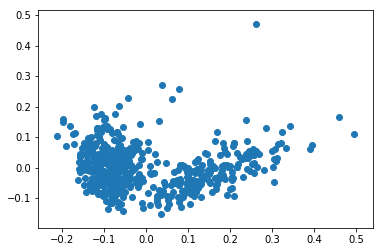

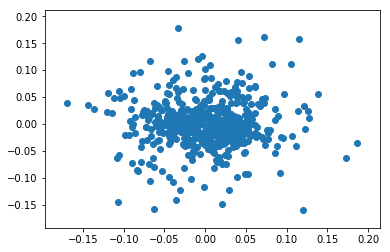

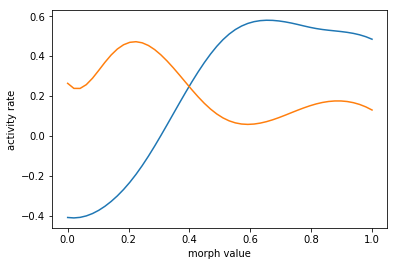

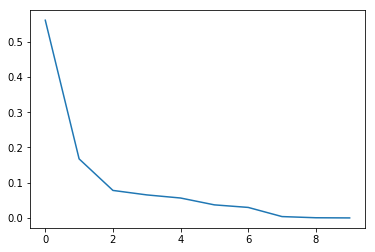

In [77]:
from sklearn import decomposition
pca = sk.decomposition.PCA(n_components=2)
km = sk.cluster.KMeans(n_clusters = 2)

Y_pca = pca.fit_transform(Y[:k+1,:])
f,ax = plt.subplots()
ax.scatter(Y_pca[:,0],Y_pca[:,1])
f,ax = plt.subplots()
ax.scatter(Y_pca[:,2],Y_pca[:,3])
f,ax = plt.subplots()
xx = np.linspace(0,1)
ax.plot(xx,pca.singular_values_[0]*pca.components_[0,:] +pca.mean_)
ax.plot(xx,pca.singular_values_[1]*pca.components_[1,:]+pca.mean_)
# ax.plot(xx,pca.singular_values_[2]*pca.components_[2,:]+pca.mean_)
# ax.plot(xx,pca.components_[3,:]+pca.mean_)
# ax.plot(xx,pca.components_[4,:]+pca.mean_)
# ax.plot(pca.components_[5,:]+pca.mean_)
ax.set_xlabel('morph value')
ax.set_ylabel('activity rate')


f,ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_[:10])
print(pca.explained_variance_ratio_.sum())


In [ ]:
for mouse in mice[0]:
    df_mouse = df[df['MouseName'].str.match(mouse)]
    df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout')]
    
    for i in range(1) : #df_mouse.shape[0]):

        sess = df_mouse.iloc[i]
        VRDat,C,Cd, S, A = pp.load_scan_sess(sess)
        trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
        nm = np.unique(trial_info['morphs']).shape[0]
        
        